### Getting The Data

1. Download the dataset from the [Santander Customer Satisfaction Kaggle Challenge](https://www.kaggle.com/competitions/santander-customer-satisfaction/data).
2. Place all three files [`train.csv` `test.csv` `sample_submission.csv`] into the `Kaggle` Folder in project root directory

### 1. Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

### 2. Loading the data

In [2]:
df = pd.read_csv("Kaggle/train.csv")

#### Basic information of data:

In [3]:
df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


### 3. Checking for missing values in the Data

In [4]:
# Identify columns with missing values and display their counts
missing = df.isnull().sum()
missing_with_values = missing[missing > 0]

if not missing_with_values.empty:
    print("Columns with missing values:\n")
    for col, count in missing_with_values.items():
        print(f"- {col}: {count} missing values")
else:
    print("No missing values found in the dataset.")


No missing values found in the dataset.


### 4. Checking for Duplicate Data

In [5]:
# Drop the 'ID' (commonly a unique identifier)
df = df.drop("ID", axis=1)

# Find duplicate rows
duplicates = df[df.duplicated()]
    
# Display result
if not duplicates.empty:
    styled = (
        duplicates.head(20)  # Limit preview to 20 rows
        .style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
            {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]}
        ])
        .set_caption(" Preview of Duplicate Rows")
        .hide(axis="index")
    )
    display(styled)
    print(f"\nNumber of duplicate rows: {len(duplicates)} (showing up to 20 rows)")
else:
    print("No duplicate rows found in the dataset.")


Number of duplicate rows: 4807 (showing up to 20 rows)


Many of the duplicate rows appear to result from multiple instances with identical data, which became visible only after the unique `id` column was dropped. These duplicates likely represent genuine repeat entries rather than errors. Therefore, I decided **not to remove** them, as they may carry meaningful patterns relevant to customer behavior.

### 4. Find and drop constant columns

In [6]:
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=constant_columns)

print(f"Removed {len(constant_columns)} constant columns: {constant_columns}")

Removed 34 constant columns: ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']


### 5. Remove redundancy between features (duplicates of other columns)

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropDuplicateFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.duplicated_feature_sets_ = []
        
    def fit(self, X, y=None):
        X = X.copy()
        seen = {}
        self.duplicated_feature_sets_ = []
        
        for col in X.columns:
            col_bytes = X[col].values.tobytes()
            if col_bytes in seen:
                self.duplicated_feature_sets_.append((seen[col_bytes], col))
            else:
                seen[col_bytes] = col
        return self
    
    def transform(self, X):
        X = X.copy()
        to_drop = [dup[1] for dup in self.duplicated_feature_sets_]
        return X.drop(columns=to_drop)


duplicates = DropDuplicateFeatures()
duplicates.fit(df)
print("Duplicate columns:", duplicates.duplicated_feature_sets_)
df = duplicates.transform(df)


Duplicate columns: [('ind_var13_medio_0', 'ind_var13_medio'), ('ind_var18_0', 'ind_var18'), ('ind_var26_0', 'ind_var26'), ('ind_var25_0', 'ind_var25'), ('ind_var6_0', 'ind_var29_0'), ('ind_var6', 'ind_var29'), ('ind_var32_0', 'ind_var32'), ('ind_var34_0', 'ind_var34'), ('ind_var37_0', 'ind_var37'), ('ind_var40', 'ind_var39'), ('num_var13_medio_0', 'num_var13_medio'), ('num_var18_0', 'num_var18'), ('num_var26_0', 'num_var26'), ('num_var25_0', 'num_var25'), ('num_var6_0', 'num_var29_0'), ('num_var6', 'num_var29'), ('num_var32_0', 'num_var32'), ('num_var34_0', 'num_var34'), ('num_var37_0', 'num_var37'), ('num_var40', 'num_var39'), ('saldo_var6', 'saldo_var29'), ('delta_imp_reemb_var13_1y3', 'delta_num_reemb_var13_1y3'), ('delta_imp_reemb_var17_1y3', 'delta_num_reemb_var17_1y3'), ('delta_imp_reemb_var33_1y3', 'delta_num_reemb_var33_1y3'), ('delta_imp_trasp_var17_in_1y3', 'delta_num_trasp_var17_in_1y3'), ('delta_imp_trasp_var17_out_1y3', 'delta_num_trasp_var17_out_1y3'), ('delta_imp_trasp_v

### 6. Identify binary categorical columns

In [8]:
binary_categoricals = []

for col in df.columns:
    unique_vals = df[col].dropna().unique()
    if df[col].dtype == 'object' or df[col].dtype.name == 'category' or df[col].dtype == 'bool':
        if len(unique_vals) == 2:
            binary_categoricals.append((col, unique_vals))
    elif df[col].dtype in ['int64', 'float64']:
        if len(unique_vals) == 2:
            binary_categoricals.append((col, unique_vals))

print(f"Number of binary categorical features: {len(binary_categoricals)}")
for col, values in binary_categoricals:
    print(f"{col}: {values}")

Number of binary categorical features: 86
ind_var1_0: [0 1]
ind_var1: [0 1]
ind_var5_0: [1 0]
ind_var5: [0 1]
ind_var6_0: [0 1]
ind_var6: [0 1]
ind_var8_0: [0 1]
ind_var8: [0 1]
ind_var12_0: [0 1]
ind_var12: [0 1]
ind_var13_0: [0 1]
ind_var13_corto_0: [0 1]
ind_var13_corto: [0 1]
ind_var13_largo_0: [0 1]
ind_var13_largo: [0 1]
ind_var13_medio_0: [0 1]
ind_var13: [0 1]
ind_var14_0: [0 1]
ind_var14: [0 1]
ind_var17_0: [0 1]
ind_var17: [0 1]
ind_var18_0: [0 1]
ind_var19: [0 1]
ind_var20_0: [0 1]
ind_var20: [0 1]
ind_var24_0: [0 1]
ind_var24: [0 1]
ind_var25_cte: [0 1]
ind_var26_0: [0 1]
ind_var26_cte: [0 1]
ind_var25_0: [0 1]
ind_var30_0: [1 0]
ind_var30: [0 1]
ind_var31_0: [0 1]
ind_var31: [0 1]
ind_var32_cte: [0 1]
ind_var32_0: [0 1]
ind_var33_0: [0 1]
ind_var33: [0 1]
ind_var34_0: [0 1]
ind_var37_cte: [0 1]
ind_var37_0: [0 1]
ind_var39_0: [1 0]
ind_var40_0: [0 1]
ind_var40: [0 1]
ind_var41_0: [1 0]
ind_var44_0: [0 1]
ind_var44: [0 1]
num_var6_0: [0 3]
num_var6: [0 3]
num_var8: [0 3]
nu

### Target Variable Analysis

The target variable in this dataset is used for a **classification task**. It is **encoded as binary values: `0` and `1`**, where each class represents a customer satisfaction category (i.e., dissatisfied vs. satisfied). This binary encoding makes it suitable for machine learning models designed for binary classification problems such as logistic regression, decision trees, or random forests.

### 7. Checking and Dealing with Class Imbalance

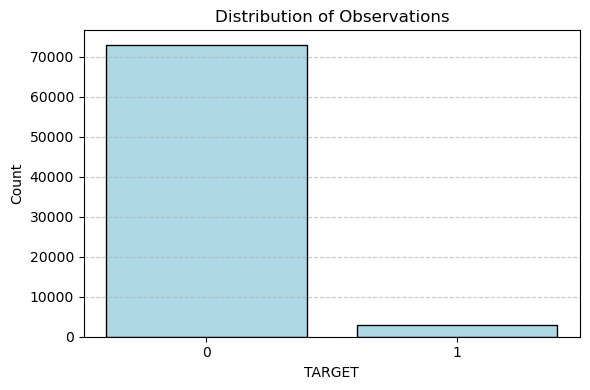

In [9]:
#Visualizing Distribution:

# Step 1: Count the number of observations per TARGET value
target_counts = df['TARGET'].value_counts().sort_index()

# Step 2: Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(target_counts.index.astype(str), target_counts.values, color='lightblue', edgecolor='black')

# Step 3: Add titles and labels
plt.title('Distribution of Observations')
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 4: Show the plot
plt.tight_layout()
plt.show()

The illustration shows a huge skew towards class 0, indicating that a majority of the customers in the dataset are satisfied. This imbalance suggests that instances of dissatisfaction (class 1) are fewer in comparison. As a result, the model may become biased during training, favoring the majority class and potentially underperforming when predicting minority class cases.

### Train-test split (just for deciding model for now)

In [10]:
X = df.drop(['TARGET'], axis=1)
y = df['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [11]:
# Baseline Model (No Resampling)
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]

print("Baseline ROC-AUC:", roc_auc_score(y_val, y_pred))

Baseline ROC-AUC: 0.8386772098301738


In [12]:
# Class Weight Model
model_weighted = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                                eval_metric='logloss')
model_weighted.fit(X_train, y_train)
y_pred_weighted = model_weighted.predict_proba(X_val)[:, 1]

print("Class-Weighted ROC-AUC:", roc_auc_score(y_val, y_pred_weighted))

Class-Weighted ROC-AUC: 0.8229068880110629


In [13]:
# Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

model_ros = XGBClassifier(eval_metric='logloss')
model_ros.fit(X_ros, y_ros)
y_pred_ros = model_ros.predict_proba(X_val)[:, 1]

print("Random Oversampling ROC-AUC:", roc_auc_score(y_val, y_pred_ros))

Random Oversampling ROC-AUC: 0.8172688650032468


In [14]:
# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

model_smote = XGBClassifier(eval_metric='logloss')
model_smote.fit(X_smote, y_smote)
y_pred_smote = model_smote.predict_proba(X_val)[:, 1]

print("SMOTE ROC-AUC:", roc_auc_score(y_val, y_pred_smote))

SMOTE ROC-AUC: 0.8092469356357228


In [15]:
# Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

model_rus = XGBClassifier(eval_metric='logloss')
model_rus.fit(X_rus, y_rus)
y_pred_rus = model_rus.predict_proba(X_val)[:, 1]

print("Random Undersampling ROC-AUC:", roc_auc_score(y_val, y_pred_rus))

Random Undersampling ROC-AUC: 0.8297632281747234


In [16]:
print("\n--- ROC-AUC Comparison ---")
print("Baseline:", roc_auc_score(y_val, y_pred))
print("Class Weighted:", roc_auc_score(y_val, y_pred_weighted))
print("Oversampling:", roc_auc_score(y_val, y_pred_ros))
print("SMOTE:", roc_auc_score(y_val, y_pred_smote))
print("Undersampling:", roc_auc_score(y_val, y_pred_rus))


--- ROC-AUC Comparison ---
Baseline: 0.8386772098301738
Class Weighted: 0.8229068880110629
Oversampling: 0.8172688650032468
SMOTE: 0.8092469356357228
Undersampling: 0.8297632281747234


Surprisingly, the baseline model without any resampling techniques achieved the highest ROC-AUC score of 0.8387, outperforming all other methods including class weighting, oversampling, SMOTE, and undersampling. Despite the significant class imbalance, the built-in handling of imbalanced classes appears to be effective, eliminating the need for additional data manipulation in this case.

Given these results, the next step is to analyze precision, recall, and F1-score, particularly for the minority class (TARGET = 1), to ensure that dissatisfied customers are not being overlooked by the model.

Definitions  
+ Precision: Of all the customers predicted to be unsatisfied, how many actually were?

+ Recall: Of all truly unsatisfied customers, how many did the model correctly identify?

+ F1-Score: A harmonic mean of precision and recall, balancing both concerns.


In [17]:
results = []

# Define models and predictions
model_outputs = {
    "Baseline": y_pred,
    "Class Weighted": y_pred_weighted,
    "Oversampling": y_pred_ros,
    "SMOTE": y_pred_smote,
    "Undersampling": y_pred_rus
}

# Loop through each model
for name, preds in model_outputs.items():
    y_pred_label = (preds > 0.5).astype(int)
    report = classification_report(y_val, y_pred_label, output_dict=True)
    
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    
    results.append([name, f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}"])

# Create HTML table
headers = ["Model", "Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)"]
html_table = tabulate(results, headers=headers, tablefmt='html')

# Display the HTML
display(HTML(html_table))

Model,Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
Baseline,0.4286,0.01,0.0195
Class Weighted,0.1495,0.6578,0.2436
Oversampling,0.1411,0.6412,0.2313
SMOTE,0.186,0.3887,0.2516
Undersampling,0.1104,0.7724,0.1932


Based on the evaluation metrics, **Class Weighted** sampling emerges as the most suitable approach for this task. While the **baseline model** showed the highest ROC-AUC, it performed extremely poorly in identifying dissatisfied customers, with a recall close to 1% and an F1-score near zero. 

Among the resampling techniques:

+ Undersampling had the highest recall (77.2%) but the lowest precision (11%), leading to too many false positives.

+ SMOTE achieved the best F1-score (0.2516), but its lower recall (38.9%) means it missed many actual dissatisfied customers.

+ Class Weighted stood out by offering a strong balance:

        + Recall: 65.8%

        + Precision: 14.9%

        + F1-score: 0.2436

Given these results, class weighting is the most reliable method, effectively identifying dissatisfied customers while keeping false positives within a reasonable range.

In [18]:
# Calculate class weight
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

# Train the model using the entire dataset
model_full = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)
model_full.fit(X, y)

# Predict on the same data (just to confirm it trains — not for model evaluation)
y_pred = model_full.predict(X)
y_proba = model_full.predict_proba(X)[:, 1]

# Print classification report and AUC (on training data)
print("Classification Report:\n", classification_report(y, y_pred))
print("ROC-AUC Score on full dataset:", roc_auc_score(y, y_proba))

Scale Pos Weight: 24.27
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     73012
           1       0.19      0.90      0.31      3008

    accuracy                           0.84     76020
   macro avg       0.59      0.87      0.61     76020
weighted avg       0.96      0.84      0.89     76020

ROC-AUC Score on full dataset: 0.9336689844630611


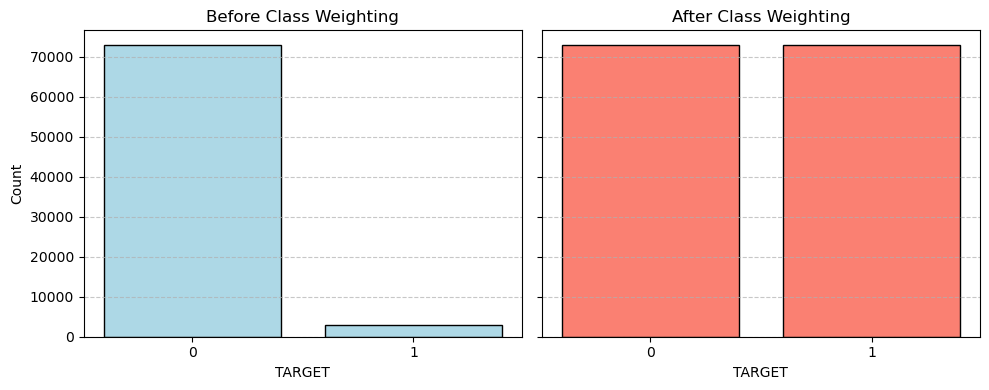

In [19]:
# Simulate the weighted effect for visualization
weighted_counts = target_counts.copy()
weighted_counts[1] = weighted_counts[1] * scale_pos_weight

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Original distribution
axes[0].bar(target_counts.index.astype(str), target_counts.values, color='lightblue', edgecolor='black')
axes[0].set_title("Before Class Weighting")
axes[0].set_xlabel("TARGET")
axes[0].set_ylabel("Count")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Weighted view (for illustration)
axes[1].bar(weighted_counts.index.astype(str), weighted_counts.values, color='salmon', edgecolor='black')
axes[1].set_title("After Class Weighting")
axes[1].set_xlabel("TARGET")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [20]:
# Final shape of the cleaned data
print("Final shape of the dataset:", df.shape)
print(df.columns)

# Save to CSV
import os
directory = "Out"
if not os.path.exists(directory):
    os.makedirs(directory)
df.to_csv(directory + "/cleaned_training_data.csv", index=False)
print("Cleaned data saved to '" + directory + "/cleaned_training_data.csv'")

Final shape of the dataset: (76020, 307)
Index(['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3', 'imp_op_var40_ult1',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=307)
Cleaned data saved to 'Out/cleaned_training_data.csv'
